## Setup

Choose the target board. For the time being, you can use `minized`, `pynqz1`, `pynqz2`, `cmoda735t`. You may need to install the proper board files for the chosen board.

In [1]:
## ZCU106
#board_name='zcu106'
#fpga_part='xczu7ev-ffvc1156-2-e'
 
## Ultra96
#board_name='ultra96'
#fpga_part='xczu3eg-sbva484-1-e'

## Pynq-Z1
#board_name='pynqz1'
#fpga_part='xc7z020clg400-1'

## Pynq-Z2
board_name='pynqz2'
fpga_part='xc7z020clg400-1'

## MiniZed
#board_name='minized'
#fpga_part='xc7z007sclg225-1'

##Cmod A7-35t
#board_name='cmoda735t'
#fpga_part='xc7a35tcpg236-1'

Let's import the libraries, call the magic functions, and setup the environment variables.

In [2]:
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects

import numpy as np

import hls4ml

from callbacks import all_callbacks
import plotting

import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ['PATH'] = '/tools/Xilinx/Vivado/2019.1/bin:' + os.environ['PATH']

def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

-----------------------------------
Xilinx Vivado HLS is in the PATH
-----------------------------------


## Load the dataset

This is a lot like the previous notebooks, so we will go through quickly.

First, we fetch the dataset from file, do the normalization and make a train and test split.

We save the test dataset to files so that we can use them later.

In [3]:
#load processed test data
from sklearn.utils import shuffle
X = np.load('./test_data/test_data_frames_4_hops_512_fft_1024_mels_64_power_2.0.npy', allow_pickle=True)
y = np.load('./test_data/test_data_frames_4_hops_512_fft_1024_mels_64_power_2.0_ground_truths.npy', allow_pickle=True)
y_keras = []
#use a quarter of the test_set to save time
for i in range(len(X)):
    quarter = int(len(X[i])/4)
    assert len(X) == len(y)
    X[i], y[i] = shuffle(X[i], y[i])
    X[i], y[i] = X[i][0:quarter],  y[i][0:quarter]

## Train or Load Model

In [4]:
import keras_model
train = False
#not os.path.exists('model/KERAS_check_best_model.h5')
if train:
    model.compile(loss="mean_squared_error", optimizer="adam")
        
    print("Shape of training data element is: {}".format(train_data[0].shape))
    history = model.fit(train_data,
                        train_data,
                        epochs=100,
                        batch_size=512,
                        shuffle=true,
                        validation_split=0.1,
                        verbose=1,
                        callbacks=callbacks)
    

else:
    #model_file = 'model/train_config_bits_6_frames_4_mels_64_hidDims_64_encDims_8_bn_True_l1reg0/model_ToyCar.h5'
    model_file = "model/tiny_qkeras_model/train_config_bits_6_frames_4_mels_64_encDims_8_hidDims_64_bn_True_qbatch_False_l1reg_0/model_ToyCar.h5"
    if not os.path.exists(model_file):
        print("{} model not found at path ".format(model_file))

    model = keras_model.load_model(model_file)
    model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
q_dense (QDense)             (None, 16)                4112      
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
q_activation (QActivation)   (None, 16)                0         
_________________________________________________________________
q_dense_1 (QDense)           (None, 8)                 136       
_________________________________________________________________
batch_normalization_1 (Batch (None, 8)                 32        
_________________________________________________________________
q_activation_1 (QActivation) (None, 8)                

## Check model sparisty

% of zeros = 0.0


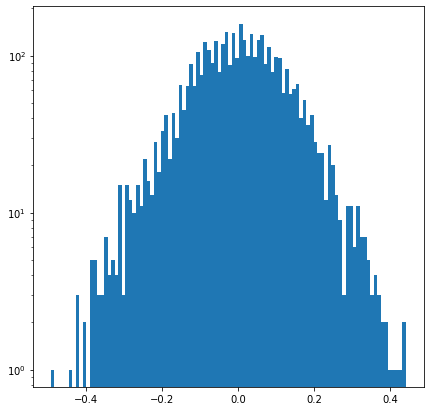

In [5]:
w = model.layers[1].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))

## Check accuracy

Do not expect a good accuracy because of the low amount of neurons. I could have done better than this, but as long as it fits both Pynq-Z1 and MiniZed, it is fine with us.

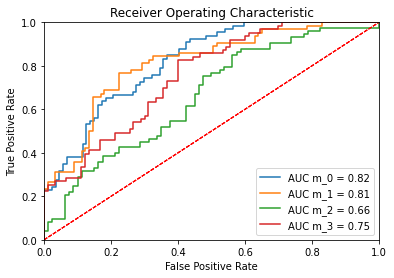

In [6]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
import plotting
import numpy

#load processed test data
X = np.load('./test_data/test_data_frames_4_hops_512_fft_1024_mels_64_power_2.0.npy', allow_pickle=True)
y = np.load('./test_data/test_data_frames_4_hops_512_fft_1024_mels_64_power_2.0_ground_truths.npy', allow_pickle=True)
y_keras = []
#use a quarter of the test_set to save time
for i in range(len(X)):
    quarter = int(len(X[i])/4)
    assert len(X) == len(y)
    X[i], y[i] = shuffle(X[i], y[i])
    X[i], y[i] = X[i][0:quarter],  y[i][0:quarter]

#perform inference
for index, X_data in enumerate(X):
    y_pred = [0. for ind in X_data]
    for file_idx, X_test in enumerate(X_data):
        predictions = model.predict(X_test)
        errors = np.mean(np.square(X_test-predictions), axis=1)
        y_pred[file_idx] = numpy.mean(errors)
        
    #generate auc and roc metrics
    y_test = y[index]
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    y_keras.append(y_pred)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label = 'AUC m_{} = {}'.format(index, round(roc_auc,2)), linewidth = 1.5)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--', linewidth=1)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.show()


## Make an hls4ml configuration (Step 2)

Notice we're using `Strategy: Resource` for every layer, and `ReuseFactor: 64`. The Programmable Logic (FPGA part) of the Pynq-Z1 SoC is not big compared to VU9P type of parts.

We also use some settings which are good for QKeras.

Notice the `fpga_part:'xc7z020clg400-1'`.

In [7]:

hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')
hls_config['Model'] = {}
hls_config['Model']['ReuseFactor'] = 1024
hls_config['Model']['Strategy'] = 'Resource'
hls_config['Model']['Precision'] = 'ap_fixed<32,16>'
hls_config['LayerName']['input_1']['Precision'] = 'ap_fixed<8,8>'

hls_config['LayerName']['q_dense']['Precision']['weight'] = 'ap_fixed<7,1>'
hls_config['LayerName']['q_dense']['Precision']['bias'] = 'ap_fixed<7,1>'
hls_config['LayerName']['q_dense']['ReuseFactor'] = 1024

hls_config['LayerName']['batch_normalization']['Precision']['scale'] = 'ap_fixed<16,6>'
hls_config['LayerName']['batch_normalization']['Precision']['bias'] = 'ap_fixed<16,6>'
hls_config['LayerName']['batch_normalization']['ReuseFactor'] = 1024

hls_config['LayerName']['q_activation']['Precision']['result'] = 'ap_fixed<7,4>'
hls_config['LayerName']['q_activation']['ReuseFactor'] = 1024

for i in range(1,2):
    
    hls_config['LayerName']['q_dense_{}'.format(i)]['Precision']['weight'] = 'ap_fixed<7,1>'
    hls_config['LayerName']['q_dense_{}'.format(i)]['Precision']['bias'] = 'ap_fixed<7,1>'
    hls_config['LayerName']['q_dense_{}'.format(i)]['ReuseFactor'] = 1024

    hls_config['LayerName']['batch_normalization_{}'.format(i)]['Precision']['scale'] = 'ap_fixed<16,6>'
    hls_config['LayerName']['batch_normalization_{}'.format(i)]['Precision']['bias'] = 'ap_fixed<16,6>'
    hls_config['LayerName']['batch_normalization_{}'.format(i)]['ReuseFactor'] =1024

    hls_config['LayerName']['q_activation_{}'.format(i)]['Precision']['result'] = 'ap_fixed<7,4>'
    hls_config['LayerName']['q_activation_{}'.format(i)]['ReuseFactor'] = 1024
    
#final output
hls_config['LayerName']['q_dense_2']['Precision']['weight'] = 'ap_fixed<7,7>'
hls_config['LayerName']['q_dense_2']['Precision']['bias'] = 'ap_fixed<7,7>'
hls_config['LayerName']['q_dense_2']['ReuseFactor'] = 1024

# print("-----------------------------------")
plotting.print_dict(hls_config)
# print("-----------------------------------")

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: q_dense, layer type: QDense
Layer name: batch_normalization, layer type: BatchNormalization
Layer name: q_activation, layer type: QActivation
Layer name: q_dense_1, layer type: QDense
Layer name: batch_normalization_1, layer type: BatchNormalization
Layer name: q_activation_1, layer type: QActivation
Layer name: q_dense_2, layer type: QDense
Model
  ReuseFactor:       1024
  Strategy:          Resource
  Precision:         ap_fixed<32,16>
LayerName
  input_1
    Precision:       ap_fixed<8,8>
  q_dense
    Precision
      weight:        ap_fixed<7,1>
      bias:          ap_fixed<7,1>
    ReuseFactor:     1024
  batch_normalization
    Precision
      scale:         ap_fixed<16,6>
      bias:          ap_fixed<16,6>
    ReuseFactor:     1024
  q_activation
    Precision
      result:        ap_fixed<7,4>
    ReuseFactor:     1024
  q_dense_1
    Precision
      weight:        ap_fixed<7,1>
      bias:      

## Convert and Compile

You can set some target specific configurations:

- Define the `interface`, which for our current setup should always be `m_axi`.
- Define the  width of the AXI bus. For the time being, use `16` that is each clock cycle you transfer a single input or output value (`ap_fixed<16,*>`).
- Define the implementation. For the time being, use `serial`.

In [8]:
interface = 'm_axi' # 's_axilite', 'm_axi', 'hls_stream'
axi_width = 16 # 16, 32, 64
implementation = 'serial' # 'serial', 'dataflow'

In [9]:
output_dir='hls/' + '256x16x8x256_' + '_' + interface + '_' + str(axi_width) + '_' + implementation + '_prj' 
'''
backend_config = hls4ml.converters.create_backend_config(fpga_part=fpga_part)
backend_config['ProjectName'] = 'anomaly_detector'
backend_config['KerasModel'] = model
backend_config['HLSConfig'] = hls_config
backend_config['OutputDir'] = output_dir
backend_config['Backend'] = 'Pynq'
backend_config['Interface'] = interface
backend_config['IOType'] = 'io_parallel'
backend_config['AxiWidth'] = str(axi_width)
backend_config['Implementation'] = implementation
backend_config['ClockPeriod'] = 10

#print("-----------------------------------")
#plotting.print_dict(backend_config)
#print("-----------------------------------")
'''
# hls_model = hls4ml.converters.keras_to_hls(backend_config)
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                                hls_config=hls_config,
                                                                output_dir=output_dir,
                                                                fpga_part=fpga_part,
                                                                clock_period=10,
                                                                io_type='io_parallel',
                                                                project_name='anomaly_detector')

_ = hls_model.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, current shape: [[None, 256]]
Layer name: q_dense, layer type: QDense, current shape: [[None, 256]]
Layer name: batch_normalization, layer type: BatchNormalization, current shape: [[None, 16]]
Layer name: q_activation, layer type: Activation, current shape: [[None, 16]]
Layer name: q_dense_1, layer type: QDense, current shape: [[None, 16]]
Layer name: batch_normalization_1, layer type: BatchNormalization, current shape: [[None, 8]]
Layer name: q_activation_1, layer type: Activation, current shape: [[None, 8]]
Layer name: q_dense_2, layer type: QDense, current shape: [[None, 8]]
Creating HLS model
Writing HLS project
Done


## Profiling

Profiling weights
Profiling activations
   input_1
   q_dense
   batch_normalization
   q_activation
   q_dense_1
   batch_normalization_1
   q_activation_1
   q_dense_2


(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

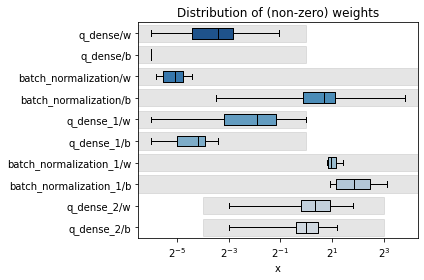

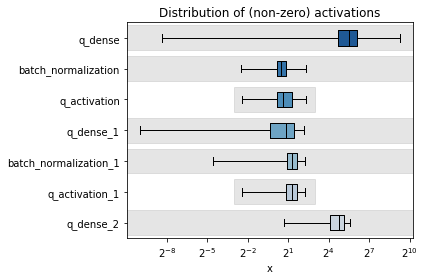

In [10]:
%matplotlib inline
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=X[0][0])

## Prediction and Comparison


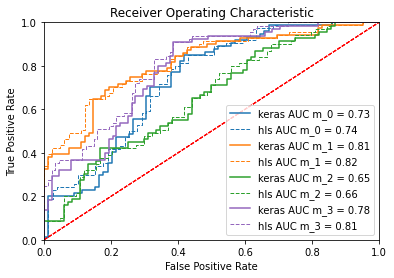

In [11]:
#load processed test data
X = np.load('./test_data/test_data_frames_4_hops_512_fft_1024_mels_64_power_2.0.npy', allow_pickle=True)
y = np.load('./test_data/test_data_frames_4_hops_512_fft_1024_mels_64_power_2.0_ground_truths.npy', allow_pickle=True)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']

#use a quarter of the test_set to save time
for i in range(len(X)):
    quarter = int(len(X[i])/4)
    assert len(X) == len(y)
    X[i], y[i] = shuffle(X[i], y[i])
    X[i], y[i] = X[i][0:quarter],  y[i][0:quarter]

#perform inference
for index, X_data in enumerate(X):
    keras_pred = [0. for ind in X_data]
    hls_pred = [0. for ind in X_data]
    for file_idx, X_test in enumerate(X_data):
        keras_predictions = model.predict(X_test)
        keras_errors = np.mean(np.square(X_test-keras_predictions), axis=1)
        keras_pred[file_idx] = numpy.mean(keras_errors)
        
        hls_predictions = hls_model.predict(X_test)
        hls_errors = np.mean(np.square(X_test-hls_predictions), axis=1)
        hls_pred[file_idx] = numpy.mean(hls_errors)
        
    #generate auc and roc metrics
    y_test = y[index]
    k_fpr, k_tpr, k_threshold = metrics.roc_curve(y_test, keras_pred)
    k_roc_auc = metrics.auc(k_fpr, k_tpr)
    h_fpr, h_tpr, h_threshold = metrics.roc_curve(y_test, hls_pred)
    h_roc_auc = metrics.auc(h_fpr, h_tpr)


    plt.title('Receiver Operating Characteristic')
    plt.plot(k_fpr, k_tpr, label = 'keras AUC m_{} = {}'.format(index, round(k_roc_auc,2)), linewidth = 1.5, color=colors[index])
    plt.plot(h_fpr, h_tpr, label = 'hls AUC m_{} = {}'.format(index, round(h_roc_auc,2)), linewidth = 1, linestyle='--', color=colors[index])
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--', linewidth=1)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.show()


## Synthesis

In [12]:
hls_model.build(csim=False,synth=True,export=True, vsynth=True)

hls4ml.report.read_vivado_report(output_dir)

Found 1 solution(s) in hls/256x16x8x256__m_axi_16_serial_prj/anomaly_detector_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'anomaly_detector'
* Date:           Sat Apr  3 03:14:08 2021

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        anomaly_detector_prj
* Solution:       solution1
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |  10.00|     9.095|        1.25|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +------+------+------+------+----------+
    |   Latency   |   Interval  | Pipeline |
    |  min |  max |  min |  max |   Type   |
    +------+------+------+------+----------+
    |  2205|  2206|  1024|  1

## Resource Reference

See the resources availables on different boards.

```
+-----------------+---------+-------+--------+-------+-----+                    
|                 |               Resource                 |
+-----------------+---------+-------+--------+-------+-----+
|      Board      | BRAM_18K| DSP48E|   FF   |  LUT  | URAM|
+-----------------+---------+-------+--------+-------+-----+
|   PYNQ-Z1/Z2    |      280|    220|  106400|  53200|    0|
+-----------------+---------+-------+--------+-------+-----+
|     MiniZed     |      100|     66|   28800|  14400|    0|
+-----------------+---------+-------+--------+-------+-----+
``` 

## Generate .dat Files (Step 3)

The .dat files are used
- during the following `csim` step
- to generate the header files for SDK

In [13]:
'''
f = open(output_dir + '/tb_data/tb_input_features.dat', 'w')
for i in range(1):
    for j in range(len(X[i])):
        for k in range(len(X[i][j])):
            f.write('{} '.format(X[i][j]))
        f.write('\n')
f.close()

f = open(output_dir + '/tb_data/tb_output_predictions.dat', 'w')
for i in range(1):
    for j in range(len(y[i])):
        f.write('{} '.format(y[i][j]))
        f.write('\n')
f.close()
'''

"\nf = open(output_dir + '/tb_data/tb_input_features.dat', 'w')\nfor i in range(1):\n    for j in range(len(X[i])):\n        for k in range(len(X[i][j])):\n            f.write('{} '.format(X[i][j]))\n        f.write('\n')\nf.close()\n\nf = open(output_dir + '/tb_data/tb_output_predictions.dat', 'w')\nfor i in range(1):\n    for j in range(len(y[i])):\n        f.write('{} '.format(y[i][j]))\n        f.write('\n')\nf.close()\n"

## Run Vivado HLS csim (Step 4)

At this step we generate simulation traces out from the hls4ml-model.

Run the following cell to run Vivado HLS GUI:

**IMPORTANT** Click the button to `Run C Simulation`.

This will generate simulation traces with fixed-point arythmetic.

When completed close Vivado HLS GUI.

## Integrate IP in a Vivado Project and Generate Bitstream (Step 5)

**TODO** Tell the user how to visualize the `Block Diagram` to get a better understanding of the IP integration with both Zynq and MicroBlaze PS.

## Configure Software in Vivado SDK and Run HW/SW on the Board (Step 6)

Create Vivado SDK project.

- `make sdk` to configure an application with register polling
- `make sdk-irq` to configure an application with interrupts (default)

You can open a serial console, for example
```
sudo minicom -D /dev/ttyUSB0
```
and see 

![serial-console](doc/serial_console.png)